In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
%matplotlib inline

#### Working with the correct dataset (finally!)

After recognizing my error in the previous section, I grab the more appropriate columns from our cleaned dataframes, and start actually looking to test to what extent the participation of free and reduced-price breakfast & lunch participants affects the total Federal cost of the school meal programs.

In [2]:
costs = pd.read_csv('datasets/costs_processed.csv', usecols=('year', 'total_federal_cost') )
breakfast = pd.read_csv('datasets/breakfast_processed.csv', usecols=('year', 'free', 'red_price'))
lunch = pd.read_csv('datasets/lunch_processed.csv', usecols=('year', 'free', 'red_price'))

In [3]:
costs.head()

,year,total_federal_cost
0,1969,582.5
1,1970,679.4
2,1971,920.1
3,1972,1166.0
4,1973,1338.5


In [4]:
breakfast.head()

,year,free,red_price
0,1969,0.00,0.0
1,1970,0.00,0.0
2,1971,0.60,0.0
3,1972,0.81,0.0
4,1973,0.99,0.0


In [5]:
lunch.head()

,year,free,red_price
0,1969,2.9,0.0
1,1970,4.6,0.0
2,1971,5.8,0.5
3,1972,7.3,0.5
4,1973,8.1,0.5


In [6]:
combined_df = costs.set_index('year').join(breakfast.set_index('year')).join(lunch.set_index('year'), rsuffix=('_lunch'))
combined_df.head()

,total_federal_cost,free,red_price,free_lunch,red_price_lunch
year,,,,,
1969,582.5,0.00,0.0,2.9,0.0
1970,679.4,0.00,0.0,4.6,0.0
1971,920.1,0.60,0.0,5.8,0.5
1972,1166.0,0.81,0.0,7.3,0.5
1973,1338.5,0.99,0.0,8.1,0.5


By now, I've realized that the numbers from 1969 and 1970 were not really reported.  Rather than calculating an theoretical number using the reported % of total numbers, I drop those two rows from the dataframe.

In [7]:
combined_df.drop([1969, 1970], inplace=True)

In [8]:
combined_df.head()

,total_federal_cost,free,red_price,free_lunch,red_price_lunch
year,,,,,
1971,920.1,0.60,0.00,5.8,0.5
1972,1166.0,0.81,0.00,7.3,0.5
1973,1338.5,0.99,0.00,8.1,0.5
1974,1509.8,1.14,0.00,8.6,0.5
1975,1921.5,1.45,0.04,9.4,0.6


Then I sum up all of the lunch and breakfast columns to get a total_participation column, and we drop the individual values so that we're working with the just the totals.

In [9]:
combined_df['total_participation'] = combined_df.loc[:, 'free':'red_price_lunch'].sum(axis=1)

In [10]:
combined_df.head()

,total_federal_cost,free,red_price,free_lunch,red_price_lunch,total_participation
year,,,,,,
1971,920.1,0.60,0.00,5.8,0.5,6.90
1972,1166.0,0.81,0.00,7.3,0.5,8.61
1973,1338.5,0.99,0.00,8.1,0.5,9.59
1974,1509.8,1.14,0.00,8.6,0.5,10.24
1975,1921.5,1.45,0.04,9.4,0.6,11.49


In [11]:
combined_df.drop(columns=['free', 'red_price', 'free_lunch', 'red_price_lunch'], inplace=True)

In [12]:
combined_df.head()

,total_federal_cost,total_participation
year,,
1971,920.1,6.90
1972,1166.0,8.61
1973,1338.5,9.59
1974,1509.8,10.24
1975,1921.5,11.49


Once again, what we're interested in doing the analyisis on is how a %change in participation affects the overall cost of the program, so we calculate the percentage changes per year for both the participation and the cost.

In [13]:
participation_change = np.array(combined_df['total_participation'][1:])/np.array(combined_df['total_participation'][:-1])-1

In [14]:
combined_df['participation_change'] = np.append(participation_change,np.nan)

In [15]:
cost_change = np.array(combined_df['total_federal_cost'][1:])/np.array(combined_df['total_federal_cost'][:-1])-1

In [16]:
combined_df['cost_change'] = np.append(cost_change,np.nan)

In [17]:
combined_df.head()

,total_federal_cost,total_participation,participation_change,cost_change
year,,,,
1971,920.1,6.90,0.247826,0.267254
1972,1166.0,8.61,0.113821,0.147942
1973,1338.5,9.59,0.067779,0.127979
1974,1509.8,10.24,0.122070,0.272685
1975,1921.5,11.49,0.115753,0.125319


In [18]:
combined_df.tail()

,total_federal_cost,total_participation,participation_change,cost_change
year,,,,
2011,14346.674998,31.28,0.029731,0.036301
2012,14867.467846,32.21,0.014592,0.059031
2013,15745.114942,32.68,0.017442,0.038627
2014,16353.308796,33.25,0.022256,0.033968
2015,16908.794374,33.99,NaN,NaN


In [19]:
xData = combined_df['participation_change'][0:-1].values.reshape(-1,1)

yData = combined_df['cost_change'][0:-1].values

Seaborn gives us our regression plot quickly and easily, and it looks pretty good.  As we saw when we used this plotting method with the wrong data, the small size of the dataset and the cluster of values means that our confidence bands start to get quite a bit wider as we move further from 0% change, but I'd say we actually go to around +/-10% (as opposed to 5% with the previous numbers) before we start to get significantly far from our regression line.  This looks like a pretty good result!

<AxesSubplot:>

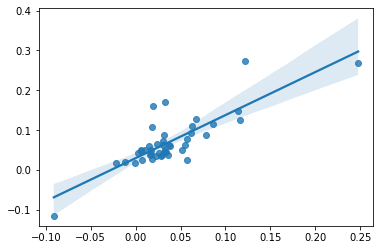

In [20]:
sns.regplot(x=xData, y=yData, label=('Participation % Change vs Total Federal Cost Change'))

In [21]:
model = smf.ols(formula='cost_change ~ participation_change', data=combined_df)

In [22]:
results = model.fit()

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cost_change   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     88.92
Date:                Fri, 10 Jun 2022   Prob (F-statistic):           6.29e-12
Time:                        09:17:57   Log-Likelihood:                 83.831
No. Observations:                  44   AIC:                            -163.7
Df Residuals:                      42   BIC:                            -160.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0292      0.007      4.132      0.000       0.015       0.043
participation_change     1.0810      0.115      9.430      0.000       0.850       1.312
==============================================================================
Omnibus:                       24.496   Durbin-Watson:                   1.417
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.783
Skew:                           1.683   Prob(JB):                     2.30e-09
Kurtosis:                       6.220   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Getting the statistical results of our regression, we see an improved R-squared value from our previous values, and our Durbin-Watson number is much more promising.  The predictive ability of this model seems plausible, at the very least.

Knowing that, we go ahead and load up the most recent data that we can find, which includes years up through 2020 (the 2021 values as listed are incomplete, so we'll need to drop those).  We'll use these values to test the regression model and see how well our predictions did.

In [24]:
future_costs = pd.read_excel('datasets/cncost-5.xlsx', header=None, skiprows=7, skipfooter=6, index_col=0, usecols="A, I",
                              names= ['year', 'total_federal_cost'])

In [25]:
future_costs.tail(10)

,total_federal_cost
year,
2012,14867.684316
2013,15745.352212
2014,16353.680118
2015,16905.486567
2016,17791.015545
2017,17904.741579
2018,18228.673633
2019,18754.454284
2020,13869.665704


In [26]:
future_costs = future_costs.loc[2015:2020]

In [27]:
future_breakfast = pd.read_excel('datasets/sbsummar-5.xlsx', header=None, skiprows=5, skipfooter=4, index_col=0, 
                                 usecols="A, B, C", names= ['year', 'free', 'red_price'])

In [28]:
future_breakfast.tail(10)

,free,red_price
year,,
2012,9.77,1.04
2013,10.16,1.02
2014,10.54,1.01
2015,11.05,0.9
2016,11.52,0.86
2017,11.6,0.84
2018,11.77,0.77
2019,11.8,0.74
2020,10.2,0.5


In [29]:
future_breakfast = future_breakfast.loc[2015:2020]

In [30]:
future_lunch = pd.read_excel('datasets/slsummar-5.xlsx', header=None, skiprows=6, skipfooter=4, index_col=0, usecols="A, B, C",
                              names= ['year', 'lunch_free', 'lunch_red_price'])

In [31]:
future_lunch.tail(10)

,lunch_free,lunch_red_price
year,,
2012,18.7,2.7
2013,18.9,2.6
2014,19.2,2.5
2015,19.8,2.2
2016,20.1,2
2017,20.0,2
2018,20.2,1.8
2019,20.1,1.7
2020,15.9,1.1


In [32]:
future_lunch = future_lunch.loc[2015:2020]

In [33]:
future_combined = future_costs.join(future_breakfast).join(future_lunch)
future_combined

,total_federal_cost,free,red_price,lunch_free,lunch_red_price
year,,,,,
2015,16905.486567,11.05,0.9,19.8,2.2
2016,17791.015545,11.52,0.86,20.1,2
2017,17904.741579,11.6,0.84,20.0,2
2018,18228.673633,11.77,0.77,20.2,1.8
2019,18754.454284,11.8,0.74,20.1,1.7
2020,13869.665704,10.2,0.5,15.9,1.1


Once again, with our raw numbers loaded up, we calculate the percentage changes (and it's at this point I kick myself for not written a function to do this back in Part 3.  If I were to keep working with this dataset, I would 100% do that.)

In [34]:
future_combined['total_participation'] = future_combined.loc[:, 'free':'lunch_red_price'].sum(axis=1)

In [35]:
future_combined.drop(columns=['free', 'red_price', 'lunch_free', 'lunch_red_price'], inplace=True)

In [36]:
participation_change = np.array(future_combined['total_participation'][1:])/np.array(future_combined['total_participation'][:-1])-1

future_combined['participation_change'] = np.append(participation_change,np.nan)

cost_change = np.array(future_combined['total_federal_cost'][1:])/np.array(future_combined['total_federal_cost'][:-1])-1

future_combined['cost_change'] = np.append(cost_change,np.nan)

future_combined

,total_federal_cost,total_participation,participation_change,cost_change
year,,,,
2015,16905.486567,33.95,0.015611,0.052381
2016,17791.015545,34.48,-0.001160,0.006392
2017,17904.741579,34.44,0.002904,0.018092
2018,18228.673633,34.54,-0.005790,0.028844
2019,18754.454284,34.34,-0.193361,-0.260460
2020,13869.665704,27.70,NaN,NaN


In [37]:
model = LinearRegression(fit_intercept=True)

In [38]:
model.fit(X = xData, y = yData)

LinearRegression()

In [39]:
x_lin = np.array([-0.2, .25])
y_lin = model.intercept_ + model.coef_ * x_lin

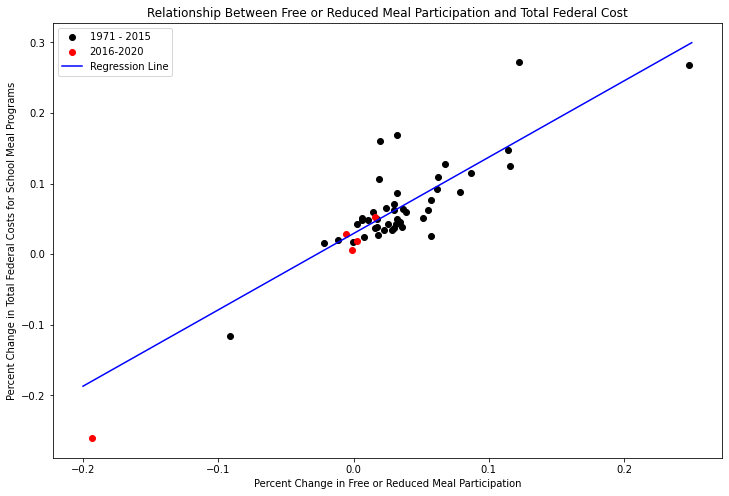

In [40]:
plt.figure(figsize=(12,8))
plt.scatter(xData, yData, color='black', label='1971 - 2015')
plt.scatter(future_combined.participation_change, future_combined.cost_change, color='red',
            label = '2016-2020')
plt.plot(x_lin, y_lin, c='blue', label='Regression Line')
plt.xlabel('Percent Change in Free or Reduced Meal Participation')
plt.ylabel('Percent Change in Total Federal Costs for School Meal Programs')
plt.title('Relationship Between Free or Reduced Meal Participation and Total Federal Cost')
plt.legend(fontsize=10)
plt.show()

And there we go!  Four out of five of the years that we didn't have in our dataset to begin with exist in our tight cluster, so it's no big surprise that they land very close to our regression line.  The red dot that is down in the corner represents the change between the years 2019 & 2020.  It's not particularly surprising that they participation numbers are way down, but what's actually pretty impressive is that the model we generated is not hugely off, despite the fact that this new datapoint could comfortably be considered an outlier compared to our training data.  At the very least, it does fall within the confidence band that the Seaborn model generated above.

#### Conclusions

In looking at our Simple Regression Model, I think there is an intuitive understanding that the participation numbers affect the overall costs of the program.  However, it's also clear that if we wanted to do a more thorough investigation, we would have to consider other factors that have a causal relationship with the reported costs.  

It's likely that we would want to adjust our cost numbers to account for inflation as a way to remove the influence of inflation from our analysis and give us a better sense of how much the participation numbers are affecting the operating costs as opposed to both just naturally increasing over time.  I also think it would be interesting to look at breakfast numbers and lunch numbers separately, especially in the case where free and paid lunches have trended in different directions over time.  

Similarly, it could be extremely interesting to seek out data regarding the state-wide disbursment of these funds and compare it with demographic information or economic indicators of those areas.  That sort of analysis could also loop in Standardized Test scores and the like if we saw some correlations there, and could end up being pretty fascinating, though it's quite beyond the scope of this particular investigation.  Regardless it is clear to me that there are quite a few more questions that we could ask, even of this small dataset, if we were to give it more of our time and attention.